<a href="https://colab.research.google.com/github/hoihui/tutorial/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# !pip3 install -U torch torchvision
import torch
cuda=torch.cuda.is_available()
torch.__version__, cuda

('1.1.0', True)

In [19]:
# !pip install -q tensorflow-gpu==2.0.0-alpha0
import tensorflow as tf
from tensorflow import keras
tf.__version__, keras.__version__

('2.0.0-alpha0', '2.2.4-tf')

# MNIST

## Torch

In [0]:
import torch

num_workers = 0  # number of subprocesses to use for data loading
batch_size = 64  # how many samples per batch to load
valid_size = 0.2 # percentage of training set to use as validation
imgsize = 28
epochs = 50
patience = 2  #early stopping

### Load Data

In [0]:
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

transform = transforms.ToTensor()
train_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=False, download=True, transform=transform)

# build train/val indices
numtrain = len(train_data)
indices = list(range(numtrain))
np.random.shuffle(indices)
split = int(valid_size * numtrain)
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

print(numtrain)

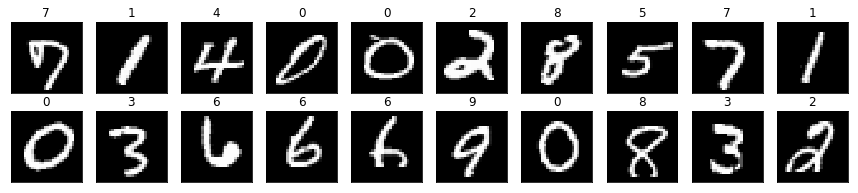

In [0]:
#visualize
images, labels = next(iter(train_loader))
fig = plt.figure(figsize=(15, 3))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(str(labels[idx].item()))

### Model

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        filters = 32               # number of convolutional filters to use
        pool_size = (2,2)          # size of pooling area for max pooling
        kernel_size = 3            # convolution kernel size
        self.conv1 = nn.Conv2d(1, filters, kernel_size, padding=1)       #in 1*imgsize*imgsize, out filters*imgsize*imgsize
        self.conv2 = nn.Conv2d(filters, filters, kernel_size, padding=1) #in filters*imgsize*imgsize, out filters*imgsize*imgsize
        self.pool = nn.MaxPool2d(*pool_size)                             #in filters*imgsize*imgsize, out filters*imgsize*imgsize/4
        self.dropout1 = nn.Dropout(0.25)
        
        self.fc1 = nn.Linear(filters * imgsize*imgsize//4, 128)  #sees filters*imgsize*imgsize/4
        self.fc2 = nn.Linear(128, 10)
        self.dropout2 = nn.Dropout(0.5)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        filters = 32
        x = x.view(-1, filters * imgsize*imgsize//4)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

model = Net()
print(model)

criterion = nn.CrossEntropyLoss()  # Linear output with CrossEntropyLoss
optimizer = torch.optim.Adadelta(model.parameters())

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25)
  (fc1): Linear(in_features=6272, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout2): Dropout(p=0.5)
)


In [0]:
images, labels = next(iter(train_loader))
print(images.shape)
print(model(images).shape)

torch.Size([64, 1, 28, 28])
torch.Size([64, 10])


### Train

In [0]:
valid_loss_min = np.Inf            # best loss so far
epochs_without_improvement = 0
import tempfile                    # tempfile for saving model
_,weightsfile=tempfile.mkstemp()

if cuda: model.cuda()
for epoch in range(epochs):
    train_loss = valid_loss = 0.
    
    # train
    model.train()
    for data, target in train_loader:
        if cuda:  data, target = data.cuda(),target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
    train_loss = train_loss/len(train_loader.sampler)
        
    # validation
    model.eval() 
    for data, target in valid_loader:
        if cuda:  data, target = data.cuda(),target.cuda()
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)        
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    print(f'Epoch {epoch+1}: \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f}')
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        torch.save(model.state_dict(), weightsfile)
        valid_loss_min = valid_loss
    else:
        epochs_without_improvement+=1
    if epochs_without_improvement>patience:
        break
        
model.load_state_dict(torch.load(weightsfile))

Epoch 1: 	Training Loss: 0.263325 	Validation Loss: 0.069751
Epoch 2: 	Training Loss: 0.086810 	Validation Loss: 0.053018
Epoch 3: 	Training Loss: 0.065068 	Validation Loss: 0.045796
Epoch 4: 	Training Loss: 0.054583 	Validation Loss: 0.044609
Epoch 5: 	Training Loss: 0.046198 	Validation Loss: 0.041176
Epoch 6: 	Training Loss: 0.040052 	Validation Loss: 0.049903
Epoch 7: 	Training Loss: 0.035796 	Validation Loss: 0.045282
Epoch 8: 	Training Loss: 0.033177 	Validation Loss: 0.045073


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

### Evaluate

In [0]:
test_loss = 0.0
class_correct = list(0. for i in range(10))  # number of correctly labeled data in each class
class_total = list(0. for i in range(10))    # number of data in each class

model.cpu()
model.eval()
for data, target in test_loader:
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    
    prob, pred = torch.max(output, 1)  # along the 2nd axis
    correct = pred.eq(target)
    
    for i in range(len(target)):
        label = target[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss/len(test_loader.sampler)
print(f'Test Loss: {test_loss:.6f}')

for i in range(10):
    if class_total[i] > 0:
        print(f'Test Accuracy of {i}: {100*class_correct[i]/class_total[i]:.2f}% ({np.sum(class_correct[i]):.0f}/{np.sum(class_total[i]):.0f})')
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print(f'Test Accuracy (Overall): {100.*np.sum(class_correct)/np.sum(class_total):.2f}% ({np.sum(class_correct):.0f}/{np.sum(class_total):.0f})')

Test Loss: 0.038658
Test Accuracy of 0: 99.18% (972/980)
Test Accuracy of 1: 99.38% (1128/1135)
Test Accuracy of 2: 99.52% (1027/1032)
Test Accuracy of 3: 99.50% (1005/1010)
Test Accuracy of 4: 99.19% (974/982)
Test Accuracy of 5: 98.99% (883/892)
Test Accuracy of 6: 98.54% (944/958)
Test Accuracy of 7: 98.35% (1011/1028)
Test Accuracy of 8: 98.46% (959/974)
Test Accuracy of 9: 96.83% (977/1009)
Test Accuracy (Overall): 98.80% (9880/10000)


## Keras

https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py

In [0]:
from tensorflow import keras
from tensorflow.keras import layers
batch_size = 64
epochs = 50
imgsize = 28
patience = 2                 #early stopping

### Load data

In [0]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data() #mnist or fashion_mnist
print(X_train.shape, y_train.shape)

X_train = X_train.reshape(X_train.shape[0], -1)
X_test  = X_test.reshape(X_test.shape[0], -1)
X_train = X_train.astype('float32')/255  # normalize data from 0 to 1
X_test  = X_test.astype('float32') /255

# y_train = keras.utils.to_categorical(y_train, 10) # one-hot; not necessary if use sparse_categorical_crossentropy
# y_test = keras.utils.to_categorical(y_test0, 10)

print(X_train.shape, y_train.shape)

(60000, 28, 28) (60000,)
(60000, 784) (60000,)


In [0]:
# To conform to tensorflow's CNN
X_train = X_train.reshape(X_train.shape[0], imgsize, imgsize, 1)
X_test = X_test.reshape(X_test.shape[0], imgsize, imgsize, 1)
input_shape = (imgsize, imgsize, 1)

### Model

In [0]:
filters = 32                    # number of convolutional filters to use
pool_size = (2, 2)              # size of pooling area for max pooling
kernel_size = (3, 3)            # convolution kernel size

model = keras.models.Sequential()
model.add(layers.Conv2D(filters, kernel_size,   # no padding, input size is automatic
                        activation='relu',
                        input_shape=input_shape))
model.add(layers.Conv2D(filters, kernel_size, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=pool_size))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               589952    
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)              

In [0]:
print(X_train[0].shape)
print(model(X_train).shape)

(28, 28, 1)
(60000, 10)


### Train

In [0]:
from tensorflow import train
model.compile(loss='sparse_categorical_crossentropy',  # or keras.losses.categorical_crossentropy
              optimizer='adam',                 # or string 'adam'
              metrics=['accuracy'])

import tempfile
_,weightsfile=tempfile.mkstemp()
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
es=EarlyStopping(monitor='val_loss', patience=patience, verbose=1)
mc=ModelCheckpoint(weightsfile,monitor='val_loss',save_best_only=True,save_weights_only=True,verbose=0)

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,callbacks=[es,mc],
          validation_data=(X_test, y_test))
model.load_weights(weightsfile)

### Evaluate

In [0]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
y_hat = model.predict_classes(X_test)
import pandas
pandas.crosstab(y_hat, y_test)

Test loss: 0.25629680104255675
Test accuracy: 0.9055


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,876,0,17,23,1,0,127,0,1,0
1,0,978,0,5,1,0,1,0,2,0
2,16,0,875,10,65,0,85,0,2,0
3,15,15,7,910,36,0,19,0,4,0
4,6,2,57,20,841,0,65,0,3,0
5,2,0,0,1,0,992,0,18,3,9
6,79,2,43,28,56,0,687,0,1,0
7,0,0,0,0,0,7,0,955,3,31
8,6,3,1,3,0,0,16,0,981,0


[9 2 1 1 6 1 4 6 5 7 4 5 7 3 4 1 2 4 8 0 2 5 7 9 1 4 6 0 9]


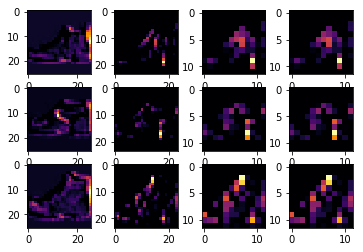

In [0]:
# Visualizing convolutions 
# https://github.com/lmoroney/dlaicourse/blob/master/Course%201%20-%20Part%206%20-%20Lesson%202%20-%20Notebook.ipynb
print(y_test[:29])  # sees #0, #23, #28 have the same label

import matplotlib.pyplot as plt
f, axarr = plt.subplots(3,4)
FIRST_IMAGE=0       #
SECOND_IMAGE=23     ##
THIRD_IMAGE=28      ###
CONVOLUTION_NUMBER = 1
layer_outputs = [layer.output for layer in model.layers]
activation_model = keras.models.Model(inputs = model.input, outputs = layer_outputs)
for x in range(0,4):
    f1 = activation_model.predict(X_test[FIRST_IMAGE].reshape(1, 28, 28, 1))[x]
    axarr[0,x].imshow(f1[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
    axarr[0,x].grid(False)
    f2 = activation_model.predict(X_test[SECOND_IMAGE].reshape(1, 28, 28, 1))[x]
    axarr[1,x].imshow(f2[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
    axarr[1,x].grid(False)
    f3 = activation_model.predict(X_test[THIRD_IMAGE].reshape(1, 28, 28, 1))[x]
    axarr[2,x].imshow(f3[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
    axarr[2,x].grid(False)

# [Human or horse](https://github.com/lmoroney/dlaicourse/blob/master/Course%202%20-%20Part%202%20-%20Lesson%202%20-%20Notebook.ipynb)

## Data

In [0]:
import os, tempfile, urllib, zipfile
os.chdir(tempfile.gettempdir())
urllib.request.urlretrieve('https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip','hh.zip')
urllib.request.urlretrieve('https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip','hhv.zip')
zipfile.ZipFile('hh.zip').extractall('horse-or-human/')
zipfile.ZipFile('hhv.zip').extractall('validation-horse-or-human/')

Create generator which also does transformation

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
        'horse-or-human/',
        target_size=(150, 150),                #reshape to this size
        batch_size=128,
        class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
        'validation-horse-or-human/',
        target_size=(150, 150), 
        batch_size=32,
        class_mode='binary')

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


## Model

In [0]:
from tensorflow import keras
model = keras.models.Sequential([
    keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(32, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)            

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.RMSprop(lr=0.001),
              metrics=['accuracy'])

## Train

In [0]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=8,  
                              epochs=15,
                              verbose=1,
                              validation_data = validation_generator,
                              validation_steps=8)

Epoch 1/15
8/8 [==============================] - 12s 2s/step - loss: 3.5277 - acc: 0.4861 - val_loss: 0.7836 - val_acc: 0.5000
Epoch 2/15
8/8 [==============================] - 9s 1s/step - loss: 0.6393 - acc: 0.5869 - val_loss: 0.3345 - val_acc: 0.8789
Epoch 3/15
8/8 [==============================] - 8s 1s/step - loss: 0.6218 - acc: 0.7419 - val_loss: 0.6543 - val_acc: 0.8125
Epoch 4/15
8/8 [==============================] - 7s 843ms/step - loss: 0.2062 - acc: 0.9212 - val_loss: 1.7586 - val_acc: 0.7656
Epoch 5/15
8/8 [==============================] - 7s 913ms/step - loss: 0.4286 - acc: 0.8298 - val_loss: 1.3087 - val_acc: 0.7734
Epoch 6/15
8/8 [==============================] - 8s 1s/step - loss: 0.5997 - acc: 0.8265 - val_loss: 1.2740 - val_acc: 0.7188
Epoch 7/15
8/8 [==============================] - 8s 993ms/step - loss: 0.1618 - acc: 0.9434 - val_loss: 1.0046 - val_acc: 0.8398
Epoch 8/15
8/8 [==============================] - 9s 1s/step - loss: 0.0800 - acc: 0.9633 - val_loss:

## Evaluate

In [0]:
model.evaluate_generator(validation_generator)  # loss, metric

[2.278491862118244, 0.83984375]

In [0]:
import glob
import numpy as np
from keras.preprocessing import image
path = 'validation-horse-or-human/horses/horse5-076.png'
img = image.load_img(path, target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])
classes = model.predict(images, batch_size=10)
classes

array([[0.]], dtype=float32)

In [0]:
# Visualize activation
# https://github.com/lmoroney/dlaicourse/blob/master/Course%201%20-%20Part%208%20-%20Lesson%204%20-%20Notebook.ipynb


# CIFAR-10

## Torch

In [0]:
import torch
import numpy as np
epochs = 50
batch_size = 20
valid_size = 0.2
imgsize = 32

### Load Data

In [0]:
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(), # randomly flip and rotate
#     transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train_data = datasets.CIFAR10('~/.pytorch/CIFAR-10_data/', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10('~/.pytorch/CIFAR-10_data/', train=False, download=True, transform=transform)

# train & val indices
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

# class names
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


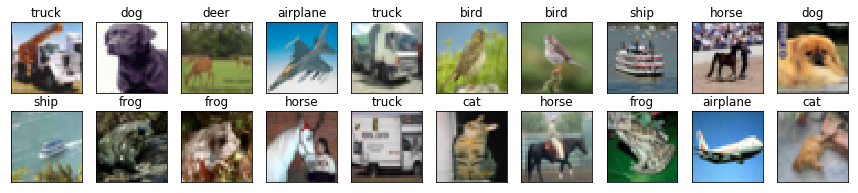

In [0]:
# just visualize
images, labels = next(iter(train_loader))
images = images.numpy()

fig = plt.figure(figsize=(15, 3))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx]/2+.5,(1,2,0)))
    ax.set_title(classes[labels[idx]])

### Model

In [0]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  #in: 3*imgsize*imgsize; out: 16*imgsize*imgsize, then pool -> 16*imgsize*imgsize/4
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1) #in: 16*imgsize*imgsize/4; out: 32*imgsize*imgsize/4, then pool -> 32*imgsize*imgsize/16
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1) #in: 32*imgsize*imgsize/16; out: 64*imgsize*imgsize/16, then pool -> 64*imgsize*imgsize/64
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * imgsize*imgsize//64, 500)
        self.fc2 = nn.Linear(500, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = x.view(-1, 64 * imgsize*imgsize//64)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = Net()
print(model)
if cuda: model.cuda()
    
criterion = nn.CrossEntropyLoss()  # Linear output with CrossEntropyLoss
optimizer = torch.optim.Adadelta(model.parameters())

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25)
)


In [0]:
images, labels = next(iter(train_loader))
print(images.shape)
print(model(images).shape)

torch.Size([20, 3, 32, 32])
torch.Size([20, 10])


### Train

In [0]:
valid_loss_min = np.Inf            # best loss so far
epochs_without_improvement = 0
import tempfile                    # tempfile for saving model
_,weightsfile=tempfile.mkstemp()

if cuda: model.cuda()
for epoch in range(epochs):
    train_loss = valid_loss = 0.
    
    # train
    model.train()
    for data, target in train_loader:
        if cuda:  data, target = data.cuda(),target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
    train_loss = train_loss/len(train_loader.sampler)
        
    # validation
    model.eval() 
    for data, target in valid_loader:
        if cuda:  data, target = data.cuda(),target.cuda()
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)        
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    print(f'Epoch {epoch+1}: \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f}')
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        torch.save(model.state_dict(), weightsfile)
        valid_loss_min = valid_loss
    else:
        epochs_without_improvement+=1
    if epochs_without_improvement>patience:
        break
        
model.load_state_dict(torch.load(weightsfile))

Epoch 1: 	Training Loss: 1.517106 	Validation Loss: 1.153209
Epoch 2: 	Training Loss: 1.162281 	Validation Loss: 1.105698
Epoch 3: 	Training Loss: 1.057955 	Validation Loss: 0.924957
Epoch 4: 	Training Loss: 1.012363 	Validation Loss: 0.937456
Epoch 5: 	Training Loss: 0.995850 	Validation Loss: 0.967144
Epoch 6: 	Training Loss: 0.989817 	Validation Loss: 0.988594


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

### Evaluate

In [0]:
test_loss = 0.0
class_correct = list(0. for i in range(10))  # number of correctly labeled data in each class
class_total = list(0. for i in range(10))    # number of data in each class

model.eval()
for data, target in test_loader:
    if cuda: data, target = data.cuda(), target.cuda()
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    
    prob, pred = torch.max(output, 1)  # along the 2nd axis
    correct = pred.eq(target)
    
    for i in range(len(target)):
        label = target[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss/len(test_loader.sampler)
print(f'Test Loss: {test_loss:.6f}')

for i in range(10):
    if class_total[i] > 0:
        print(f'Test Accuracy of {classes[i]}: {100*class_correct[i]/class_total[i]:.2f}% ({np.sum(class_correct[i]):.0f}/{np.sum(class_total[i]):.0f})')
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print(f'Test Accuracy (Overall): {100.*np.sum(class_correct)/np.sum(class_total):.2f}% ({np.sum(class_correct):.0f}/{np.sum(class_total):.0f})')

In [0]:
# just visualize
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

if cuda:images = images.cuda()

output = model(images)
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not cuda else np.squeeze(preds_tensor.cpu().numpy())

# plot
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images.cpu()[idx]/2+.5,(1,2,0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

# Cats and dogs

### Load Data

In [10]:
import urllib.request,zipfile
import os,tempfile
os.chdir(tempfile.gettempdir())
urllib.request.urlretrieve('https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip','Cat_Dog_data.zip')
zipfile.ZipFile('Cat_Dog_data.zip').extractall()
print(os.getcwd())
# data folder structure: ./Cat_Dog_data/(train|test)/(cat|dog)

/tmp


1.0


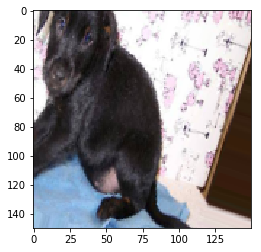

In [0]:
# Visualize example
import matplotlib.pyplot as plt
%matplotlib inline

# images, labels = next(iter(trainloader)) # torch
# image, label = images[0], labels[0]
# image = image.numpy().transpose((1, 2, 0))
images, labels = next(train_generator)     # tensorflow.keras
image, label = images[0], labels[0]

plt.imshow(image)
print(label)

## CNN w/ keras

https://github.com/lmoroney/dlaicourse/blob/master/Course%202%20-%20Part%204%20-%20Lesson%202%20-%20Notebook%20(Cats%20v%20Dogs%20Augmentation).ipynb

### data sets

In [0]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# define transformations
train_trans = ImageDataGenerator( rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')
test_trans = ImageDataGenerator(rescale=1./255)

# point to directories
train_generator = train_trans.flow_from_directory( 'Cat_Dog_data/train',
                                                   target_size=(150, 150),
                                                   batch_size=20,
                                                   class_mode='binary')
validation_generator = test_trans.flow_from_directory( 'Cat_Dog_data/test',
                                                       target_size=(150, 150),
                                                       batch_size=20,
                                                       class_mode='binary')

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


### Model

In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

### Train

In [0]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=22500//20,  # 2000 images = batch_size * steps
      epochs=100,
      validation_data=validation_generator,
      validation_steps=2500//20,  # 1000 images = batch_size * steps
      verbose=1)

In [0]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

## Transfer DenseNet w/ torch

https://github.com/udacity/deep-learning-v2-pytorch/blob/master/intro-to-pytorch/Part%207%20-%20Loading%20Image%20Data%20(Solution).ipynb

https://github.com/udacity/deep-learning-v2-pytorch/blob/master/intro-to-pytorch/Part%208%20-%20Transfer%20Learning%20(Solution).ipynb

### data sets

Dataloader:

In [0]:
import torch
from torchvision import datasets, transforms
train_transforms = transforms.Compose([transforms.RandomRotation(30),     # add randomization for robustness
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],   #normalization parameters given by the model
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder('Cat_Dog_data/train', transform=train_transforms)
test_data = datasets.ImageFolder('Cat_Dog_data/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)

### Load Model

In [0]:
from torch import nn
from torchvision import models

In [0]:
model = models.densenet121(pretrained=True)

for param in model.parameters():      # Freeze parameters of the feature detector
    param.requires_grad = False
    
print(f"old: {model.classifier}")     # seeing the input is 1024, we need to match it in our own classifier
from collections import OrderedDict   # create our own (binary) classifier
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 256)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(256, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))    
model.classifier = classifier
print(f"new: {model.classifier}")

old: Linear(in_features=1024, out_features=1000, bias=True)
new: Sequential(
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=256, out_features=2, bias=True)
  (output): LogSoftmax()
)


In [0]:
from torch import optim
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)  # only classifier's parameters

### Train

In [0]:
# estimate time on cpu/gpu:
import time
for device in ['cpu', 'cuda'][:torch.cuda.is_available()+1]:
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)  # only classifier's parameters
    model.to(device)
    
    (inputs, labels) = next(iter(trainloader))
    inputs, labels = inputs.to(device), labels.to(device)

    start = time.time()
    loss = criterion( model(inputs) , labels)
    loss.backward()
    optimizer.step()
        
    print(f"Device = {device}; First batch: {(time.time() - start):.3f} seconds")

Device = cpu; First batch: 3.553 seconds


In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if it's available
model.to(device)

epochs = 1
print_every = 5

for epoch in range(epochs):
    running_loss = 0
    for i,(inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if i % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)    # train loss
                    
                    test_loss += batch_loss.item()           # test loss                   

                    ps = torch.exp(logps)                    # test accuracy
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. Step {i} "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            model.train()

## Transfer InceptionV3 w/ keras

https://github.com/lmoroney/dlaicourse/blob/master/Course%202%20-%20Part%206%20-%20Lesson%203%20-%20Notebook.ipynb

### data sets

In [0]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# define transformations
train_trans = ImageDataGenerator( rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')
test_trans = ImageDataGenerator(rescale=1./255)

# point to directories
train_generator = train_trans.flow_from_directory( 'Cat_Dog_data/train',
                                                   target_size=(150, 150),
                                                   batch_size=20,
                                                   class_mode='binary')
validation_generator = test_trans.flow_from_directory( 'Cat_Dog_data/test',
                                                       target_size=(150, 150),
                                                       batch_size=20,
                                                       class_mode='binary')

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


### Load Model

In [0]:
# download weights
import urllib
urllib.request.urlretrieve('https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
                           'inception_weights.h5')

('inception_weights.h5', <http.client.HTTPMessage at 0xb38293b70>)

In [0]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
model = InceptionV3(input_shape = (150, 150, 3), 
                    include_top = False, 
                    weights = None)
model.load_weights('inception_weights.h5')
for layer in model.layers:
    layer.trainable = False
    
last_layer = model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [0]:
# Add a dense layer
from tensorflow.keras.optimizers import RMSprop

x = keras.layers.Flatten()(last_output)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)                  
x = keras.layers.Dense  (1, activation='sigmoid')(x)           

model = keras.Model( model.input, x)    

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

### Train

In [0]:
history = model.fit_generator( train_generator,
                               validation_data = validation_generator,
                               steps_per_epoch = 22500//20,  # assuming 100*batch_size = training dataset size
                               epochs = 20,
                               validation_steps = 2500//20,
                               verbose = 1)

In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)

## Transfer MobileNetV2 w/ tensorflow

https://www.tensorflow.org/alpha/tutorials/images/transfer_learning

In [0]:
# !pip install -q tensorflow-gpu==2.0.0-alpha0
import tensorflow as tf
from tensorflow import keras

### data sets from downloaded images

In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# define transformations
train_trans = ImageDataGenerator( rescale=1./127.5,
#                                   rotation_range=40,
#                                   width_shift_range=0.2,
#                                   height_shift_range=0.2,
#                                   shear_range=0.2,
#                                   zoom_range=0.2,
#                                   horizontal_flip=True,
                                  fill_mode='nearest')
test_trans = ImageDataGenerator(rescale=1./127.5)

# point to directories
train_generator = train_trans.flow_from_directory( 'Cat_Dog_data/train',
                                                   target_size=(160, 160),
                                                   batch_size=32,
                                                   class_mode='binary')
validation_generator = test_trans.flow_from_directory( 'Cat_Dog_data/test',
                                                       target_size=(160, 160),
                                                       batch_size=32,
                                                       class_mode='binary')

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


### Load Data from tfds

In [0]:
import tensorflow_datasets as tfds
splits = tfds.Split.TRAIN.subsplit(weighted=(8, 1, 1))

(raw_train, raw_validation, raw_test), metadata = tfds.load('cats_vs_dogs', split=list(splits),
                                                            with_info=True, as_supervised=True)

In [0]:
#conforming with MobileNetV2
IMG_SIZE = 160
def format_example(image, label):  
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [0]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [5]:
for image_batch, label_batch in train_batches.take(1):
    print(image_batch.shape, label_batch.shape)

(32, 160, 160, 3) (32,)


### Load Model

In [6]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
print(base_model(image_batch).shape)

9412608/9406464 [==============================] - 0s 0us/step
(32, 5, 5, 1280)


In [17]:
# stack with classification layer
model = tf.keras.Sequential([
  base_model,
  keras.layers.GlobalAveragePooling2D(),  #average over the spatial 5x5 spatial locations
  keras.layers.Dense(1,activation='sigmoid')
])
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


### Train

In [14]:
# for images downloaded
history = model.fit_generator( train_generator,
                               validation_data = validation_generator,
                               steps_per_epoch = 22500//32,
                               validation_steps = 2500//32,
                               epochs = 3, verbose = 1)

Epoch 1/3
703/703 [==============================] - 106s 151ms/step - loss: 0.3506 - accuracy: 0.8524 - val_loss: 0.1709 - val_accuracy: 0.9443
Epoch 2/3
703/703 [==============================] - 103s 147ms/step - loss: 0.1994 - accuracy: 0.9247 - val_loss: 0.1325 - val_accuracy: 0.9539
Epoch 3/3
703/703 [==============================] - 103s 147ms/step - loss: 0.1668 - accuracy: 0.9352 - val_loss: 0.1198 - val_accuracy: 0.9583


In [18]:
# for data loaded from tdfs
history = model.fit( train_batches,
                     validation_data=validation_batches,
                     epochs = 3, verbose = 1)

Epoch 1/3
582/582 [==============================] - 77s 132ms/step - loss: 0.3903 - accuracy: 0.8333 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/3
582/582 [==============================] - 73s 126ms/step - loss: 0.2041 - accuracy: 0.9247 - val_loss: 0.1587 - val_accuracy: 0.9453
Epoch 3/3
582/582 [==============================] - 74s 128ms/step - loss: 0.1672 - accuracy: 0.9362 - val_loss: 0.1332 - val_accuracy: 0.9526


# Transfer VGG16 to Flowers

https://github.com/udacity/deep-learning-v2-pytorch/blob/master/transfer-learning/Transfer_Learning_Solution.ipynb

In [0]:
batch_size = 20
epochs = 2  # not early stopping

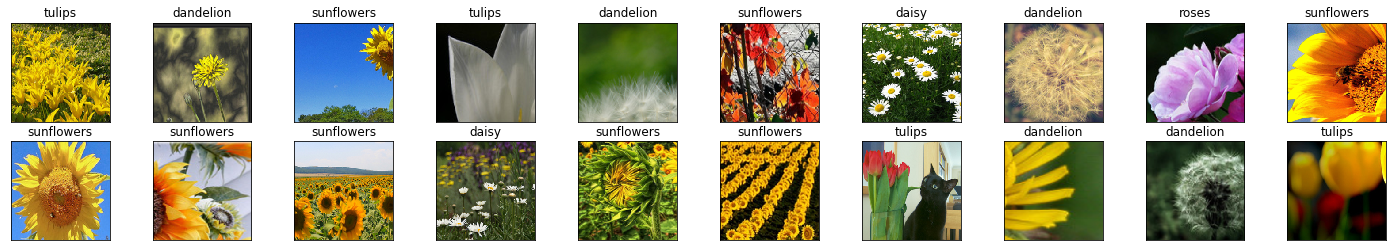

In [0]:
# visualize
images, labels = iter(train_loader).next()
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

## Load VGG19 Model

In [0]:
from torchvision import models
vgg16 = models.vgg16(pretrained=True)

for param in vgg16.features.parameters():# Freeze the feature extractor
    param.requires_grad = False

In [0]:
print(vgg16.classifier)
print(vgg16.classifier[-1].in_features) # match this for custom classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)
4096


In [0]:
import torch.nn as nn
vgg16.classifier[-1] = nn.Linear(4096, len(classes))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.01)

## Train

In [0]:
for epoch in range(epochs):
    train_loss = 0.0
    
    for i, (data, target) in enumerate(train_loader):
        if cuda: data, target = data.cuda(), target.cuda()
        
        optimizer.zero_grad()
        output = vgg16(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        if i % 20 == 0:
            print(f'Epoch {epoch}, Batch {i} loss: {train_loss / 20:.16f}')
            train_loss = 0.0

## Evaluate

In [0]:
test_loss = 0.0
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))

vgg16.eval()

for data, target in test_loader:    
    if cuda: data, target = data.cuda(), target.cuda()
        
    output = vgg16(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)    
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss/len(test_loader.dataset)
print(f'Test Loss: {test_loss:.6f}')

for i in range(5):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

In [0]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = vgg16(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))